<h2>Abnormal heartbeat detection with LSTMs and CNNs </h2>

Today, detecting abnormal heartbeat patterns is important in smartwatches.
In this project, we will try to predict heart arrhythmia with LSTMs and 1-D CNNs.

We will use MIT-BIH Arrythmia dataset (https://www.physionet.org/content/mitdb/1.0.0/).
It consists of ECG recordings of several patients (patient IDs being 100, 101, etc.) with sampling frequency of 360 (samples/sec). Experts annotated/classified specific points in the signals as normal, abnormal, or non beat.


In [1]:
# load libraries (feel free to add more) and get dataset
import os
%pip install wfdb
import wfdb
import numpy as np
import pandas as pd
import urllib.request
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.signal

from keras.layers import Bidirectional, LSTM
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv1D  # https://keras.io/api/layers/convolution_layers/convolution1d/
from keras.layers import LeakyReLU

from pywt import wavedec, dwt   # https://pywavelets.readthedocs.io/

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

urllib.request.urlretrieve('https://physionet.org/static/published-projects/mitdb/mit-bih-arrhythmia-database-1.0.0.zip', './mba_dataset.zip')
!unzip mba_dataset.zip -d mba_dataset
path_dataset='mba_dataset/mit-bih-arrhythmia-database-1.0.0/'

     |████████████████████████████████| 137 kB 4.3 MB/s 
     |████████████████████████████████| 11.2 MB 32.0 MB/s 
     |████████████████████████████████| 895 kB 41.8 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Archive:  mba_dataset.zip
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/100.atr  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/100.dat  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/100.hea  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/100.xws  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/101.atr  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/101.dat  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/101.hea  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/101.xws  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/102-0.atr  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/102.atr  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/102.dat  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/102.hea  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/102.xws  
  inflating: mba_dataset/mit-bih-arrhythmia-database-1.0.0/103.atr  
  infl

**Exploring the data**
 We will primarily use \<patientID>.atr files. There are 48 patients with a 30 minutes of recording for each.
For '100' patient, let us check what all annotations are present in his/her signal.

In [ ]:
!ls mba_dataset/mit-bih-arrhythmia-database-1.0.0
annotation = wfdb.rdann(os.path.join(path_dataset, '100'), 'atr')
print(annotation.symbol)  # symbols present in the data for patient 100

100.atr    106.dat  113.hea  119.hea  202.atr  209.xws	217.xws  230.atr
100.dat    106.hea  113.xws  119.xws  202.dat  210.atr	219.atr  230.dat
100.hea    106.xws  114.atr  121.atr  202.hea  210.dat	219.dat  230.hea
100.xws    107.atr  114.dat  121.dat  202.xws  210.hea	219.hea  230.xws
101.atr    107.dat  114.hea  121.hea  203.at_  210.xws	219.xws  231.atr
101.dat    107.hea  114.xws  121.xws  203.at-  212.atr	220.atr  231.dat
101.hea    107.xws  115.atr  122.atr  203.atr  212.dat	220.dat  231.hea
101.xws    108.at_  115.dat  122.dat  203.dat  212.hea	220.hea  231.xws
102-0.atr  108.atr  115.hea  122.hea  203.hea  212.xws	220.xws  232.atr
102.atr    108.dat  115.xws  122.xws  203.xws  213.atr	221.atr  232.dat
102.dat    108.hea  116.atr  123.atr  205.atr  213.dat	221.dat  232.hea
102.hea    108.xws  116.dat  123.dat  205.dat  213.hea	221.hea  232.xws
102.xws    109.atr  116.hea  123.hea  205.hea  213.xws	221.xws  233.atr
103.atr    109.dat  116.xws  123.xws  205.xws  214.at_	222.at_  

We can see a lot of 'N' symbols. It refers to "normal" heartbeat.
We provide below the list of symbols which we will consider as "abnormal" beats in this lab.
Any other symbol encountered in the dataset refer to "non-beat" and you **must** skip them in data preparation.
For detailed explanation about symbols, refer to https://archive.physionet.org/physiobank/annotations.shtml

In [2]:
# list of symbols for abnormal beats
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

In [3]:
# We provide function for loading an ECG file
def load_ECG_file(path):
    '''
    Input: path for patient files (excluding extension)
    Output: ECG signal, symbols (labels), indices for such symbols
    '''
    record = wfdb.rdrecord(path)
    annotation = wfdb.rdann(path, 'atr')
    signal = record.p_signal[:,0]    # ECG signal
    symbol = annotation.symbol  # symbols
    index = annotation.sample  # annotation index
    return signal, symbol, index
signal, symbol, index = load_ECG_file(os.path.join(path_dataset, '100'))  # check for yourself "signal" is ~30 min duration
print(f'Length of signal: {len(signal)}')  # ECG signal length (in terms of samples and NOT seconds); think why this corresponds to ~30 minutes of signal
print(f'Annotation symbols: {symbol}')  # annotation symbold
print(f'Annotation indices: {index}')  # annotion indices for patient 100 
print(f'Sample# {index[8]} has symbol marked as {symbol[8]} which refers to abnormal beat')  # sample 2044 is abnormal

Length of signal: 650000
Annotation symbols: ['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N',

Index contains the time in which we have a heart beat. In our case, we will use those indices as values obtained from a heartbeat detector for simplicity. For more information about heartbeat detection, you can visit https://archive.physionet.org/physiobank/database/html/mitdbdir/mitdbdir.htm

**TASK 1**: Ploting any random 10-second long portion of this ECG file. Then plot any 1-second portion which has an abnormality approximately in the middle of the signal.

In [ ]:
!pip install matplotlib==3.1.3 
import matplotlib.pyplot as plt


     |████████████████████████████████| 13.1 MB 4.3 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
wfdb 3.4.1 requires matplotlib>=3.3.4, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


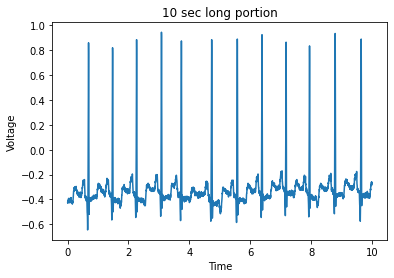

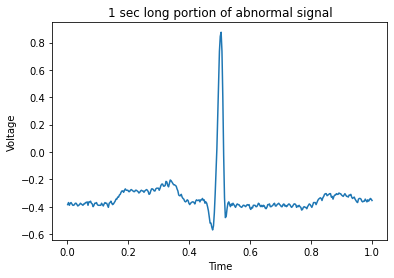

In [ ]:
T = np.array(range(1,3601))
T = T/360
plt.plot(T,signal[700:4300]) # Taking 10 sec long portion of ECG file
plt.title("10 sec long portion")
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.show()
Output = symbol.index('A') # Taking 1 sec portion of an abnormal sample
T = np.array(range(1,361))
T = T/360
plt.plot(T,signal[(index[Output]-180):(index[Output]+180)])
plt.title("1 sec long portion of abnormal signal")
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.show()

**TASK 2**: (Data Preparation) Training data is usually represented by a matrix $X \in \mathbb{R}^{N\times D}$. N is the number of training points. D is the data dimension. We will consider one data point as +/- 3 seconds sequence of samples centered around a normal or abnormal symbol. Therefore, $D=6f$, where $f$ is the sampling frequency. Goal is to construct such data matrix $X$. Our function will output the corresponding label vector $y \in \mathbb{R}^{N\times 1}$. Labels are 0 for Normal and 1 for abnormal. We should get close to a total of 100k data points. We will ignore non-beat symbols.

The patients for training set is different from the ones in test set. Roughly dividing the patients into 70:30 ratio. Simply using the patient IDs already divided into train/test below.

In [4]:
# training patient IDs
pts_train = ['100','101','102','103','104','105','106','107',
       '108','109','111','112','113','114','115','116',
       '117','118','119','121','122','123','124','200',
       '201','202','203','205','207','208','209','210']

# testing patient IDs
pts_test = ['212','213','214','215','217','219','220','221',
       '222','223','228','230','231','232','233','234']

# F0rming train and test data set
def make_dataset(train,test):
  # For training dataset
  y_train = []
  X_train = np.zeros((100000,6*360)) # Intializing train set
  count = 0
  for k in train:
    signal, symbol, index = load_ECG_file(os.path.join(path_dataset, k))
    for i in range(len(symbol)):
      if symbol[i]=='N': # Checking for normal samples
        if (index[i]-1080 > 0) and (index[i]+1080 < len(signal)): # Checking if signal fits in 3 sec window
          y_train.append(1) # Label 1 for normal
          data = signal[(index[i]-1080):(index[i]+1080)] # considering +/- 3 sec
          X_train[count]=data
          count+=1
      elif symbol[i] in abnormal: # Checking for abnormal samples with labels present in abnormal list
        if (index[i]-1080 > 0) and (index[i]+1080 < len(signal)): # Checking if signal fits in 3 sec window
          y_train.append(0) # Label 0 for abnormal
          data = signal[(index[i]-1080):(index[i]+1080)] # considering +/- 3 sec
          X_train[count]=data
          count+=1
  # For testing dataset
  y_test = []
  X_test = np.zeros((100000,6*360)) # Intializing test set
  count = 0
  for k in test:
    signal, symbol, index = load_ECG_file(os.path.join(path_dataset, k))
    for i in range(len(symbol)):
      if symbol[i]=='N': # Checking for normal samples
        if (index[i]-1080 > 0) and (index[i]+1080 < len(signal)): # Checking if signal fits in 3 sec window
          y_test.append(1) # Label 1 for normal
          data = signal[(index[i]-1080):(index[i]+1080)]  # considering +/- 3 sec
          X_test[count]=data
          count+=1
      elif symbol[i] in abnormal: # Checking for abnormal samples with labels present in abnormal list
        if (index[i]-1080 > 0) and (index[i]+1080 < len(signal)): # Checking if signal fits in 3 sec window
          y_test.append(0) # Label 0 for abnormal
          data = signal[(index[i]-1080):(index[i]+1080)]  # considering +/- 3 sec
          X_test[count]=data
          count+=1

  X_train = X_train[~np.all(X_train == 0, axis=1)] #removing all zero rows
  X_test = X_test[~np.all(X_test == 0, axis=1)] #removing all zero rows

  return X_train, y_train, X_test, y_test

In [5]:
 X_train, y_train, X_test, y_test=make_dataset(pts_train,pts_test)

**TASK 3**: (Feature Extraction) We will use pywt wavelet library to extract features for training and testing data matrices. We will do "Multilevel 1D Discrete Wavelet Transform". Daubechies dB6 wavelet is used specifically. Number of level of decompositions (called levels) is chosen to be 4. It is a hyper-parameter which is determined based on nature of signal of interest. It is highly recommended to go through the following paper. It explains how Wavelet Transform is suited for signals localized in time and frequency:

'Güler, Inan, and Elif Derya Übeylı. "ECG beat classifier designed by combined neural network model." Pattern recognition 38.2 (2005): 199-208.'

Following is a hint on how you will extract features for a signal:

The wavedec function calculates the discrete wavelet transform,

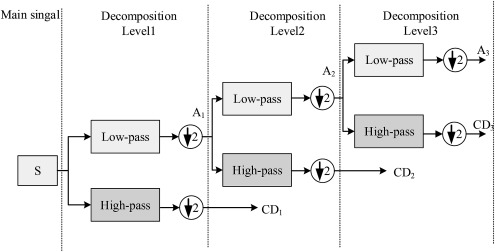

We have to do zero-padding on these features to make them equal length. Then, stacking them along a new axis to finally obtain a 2D matrix ($S \times 5$) of features per signal.

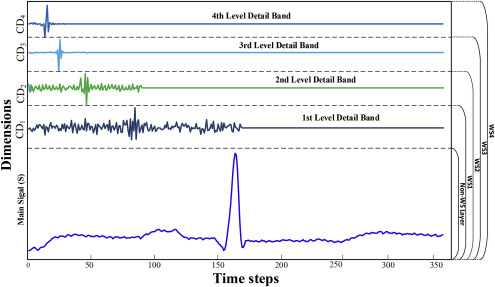

For more details, read the paper: [A novel wavelet sequence based on deep bidirectional LSTM network model for ECG signal classification](https://www.sciencedirect.com/science/article/pii/S0010482518300738?casa_token=qrJ6hAf9tkYAAAAA:7uXqrKY5WqUM6Mjc_qg7wJ4R6QA02BGFXP0o_pOKN09yB8JIXb7067JZWY88rZc8M1G6gkkA)

In [ ]:
# Extracting features
def extract_features(X):
  feat = [] 
  for i in range(len(X)):
    sig = X[i] # Considering every signal in X
    sig = scipy.signal.decimate(sig, 2)   # downsampling by 2 to reduce memory usage
    features = wavedec(sig, 'db6', level=4) # Extracting features
    length = [] # For storing length of features
    for k in range(len(features)):
      length.append(len(features[k]))
    f = np.zeros((max(length),len(features))) # For storing feature vector for each signal
    for j in range(len(features)):
      a =  np.pad(features[j],(0,max(length)-len(features[j])),'constant',constant_values=(0,0))
      f[:,j]=a
    feat.append(f)
  feat = np.array(feat) # Converting list to array
  return feat
F_train = extract_features(X_train)
F_test = extract_features(X_test)
print(F_train.shape, F_test.shape)

(70187, 545, 5) (38912, 545, 5)


**TASK 4**: Now, we are going to train a classifier to detect abnormal ECG cycles. We will train a simplified version of the LSTM-based network described in one of the [previously cited papers](https://www.sciencedirect.com/science/article/pii/S0010482518300738?casa_token=qrJ6hAf9tkYAAAAA:7uXqrKY5WqUM6Mjc_qg7wJ4R6QA02BGFXP0o_pOKN09yB8JIXb7067JZWY88rZc8M1G6gkkA). 
Using Keras, creating a single layer Bidirectional LSTM model. Choose number of output units of LSTM equals to 32. Followed by LSTM layer, we will have a dense layer with sigmoid activation and number of output units equals to 1. The model will be trained for few epochs with optimizer as Adam, loss as BCE (Binary Cross Entropy), and the metric used will be accuracy. Then report accuracy on test set.



In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(32,input_shape=(545,5)))) # LSTM layer with 32 outputs units
model.add(Dense(1, activation='sigmoid')) # Dense layer with activation function sigmoid and no. of units 1
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # Optimizer is adam and loss is BCE
model.fit(F_train, np.array(y_train), batch_size = 32, epochs=1, verbose = 1) # Fitting model 


2194/2194 [==============================] - 364s 164ms/step - loss: 0.4784 - accuracy: 0.7700


In [ ]:
score = model.evaluate(F_test, np.array(y_test), verbose = 0) # Evaluating model over test data
Accuracy = score[1]*100 
print('Accuracy is ',Accuracy)

Accuracy is  73.91549944877625


In [ ]:
# run this if you wish to print details on the model architecture
model.summary()

We will find that this particular LSTM gives only 67-75% of test accuracy (depending on your implementation), which is close to random for our setup (due to data imbalance). We will move on to a superior model (for our setup) and code 1D CNNs. Note that performance of machine learning system depends on various factors like availability of data, choice of model, data processing, model size, etc.

**TASK 5**: (1-D CNNs) Different to LSTM model, we will have 1D CNN layer this time with 32 filters, kernel size of 5 and ReLU activation. We will add a flattening layer just after this (and before dense layer). CNN examples for Keras can easily be found online. Report test accuracy.

In [ ]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(545,5))) # 1D CNN layer with 32 filter, kernel size 5 snd ReLU activation
model.add(Flatten()) # Flattening layer
model.add(Dense(1, activation='sigmoid')) # Dense layer with activation function sigmoid and no. of units 1
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # Optimizer is adam and loss is BCE
model.fit(F_train, np.array(y_train), batch_size = 32, epochs=10, verbose = 1) # Fitting model 


Epoch 1/10
2194/2194 [==============================] - 16s 4ms/step - loss: 0.1590 - accuracy: 0.9493
Epoch 2/10
2194/2194 [==============================] - 9s 4ms/step - loss: 0.0745 - accuracy: 0.9796
Epoch 3/10
2194/2194 [==============================] - 10s 4ms/step - loss: 0.0597 - accuracy: 0.9839
Epoch 4/10
2194/2194 [==============================] - 9s 4ms/step - loss: 0.0510 - accuracy: 0.9858
Epoch 5/10
2194/2194 [==============================] - 9s 4ms/step - loss: 0.0453 - accuracy: 0.9876
Epoch 6/10
2194/2194 [==============================] - 9s 4ms/step - loss: 0.0408 - accuracy: 0.9887
Epoch 7/10
2194/2194 [==============================] - 10s 4ms/step - loss: 0.0380 - accuracy: 0.9893
Epoch 8/10
2194/2194 [==============================] - 9s 4ms/step - loss: 0.0338 - accuracy: 0.9899
Epoch 9/10
2194/2194 [==============================] - 10s 4ms/step - loss: 0.0317 - accuracy: 0.9907
Epoch 10/10
2194/2194 [==============================] - 9s 4ms/step - loss: 0

In [ ]:
score = model.evaluate(F_test, np.array(y_test), verbose = 0)  #Evaluating model over test data
Accuracy = score[1]*100
print('Accuracy is ',Accuracy)

Accuracy is  83.58861207962036


**TASK 6**: (Deep CNNs) Repeating the previous task by replacing the single convolutional layer with two of them, thereby making the model deeper. 

In [ ]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(545,5))) # 1D CNN layer with 32 filter, kernel size 5 snd ReLU activation
model.add(Conv1D(filters=32, kernel_size=5, activation='relu')) # Another 1D CNN layer with 32 filter, kernel size 5 snd ReLU activation
model.add(Flatten()) # Flattening layer
model.add(Dense(1, activation='sigmoid')) # Dense layer with activation function sigmoid and no. of units 1
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # Optimizer is adam and loss is BCE
model.fit(F_train, np.array(y_train), batch_size = 32, epochs=15, verbose = 1) # Fitting model 


Epoch 1/15
2194/2194 [==============================] - 25s 6ms/step - loss: 0.1254 - accuracy: 0.9606
Epoch 2/15
2194/2194 [==============================] - 14s 6ms/step - loss: 0.0546 - accuracy: 0.9851
Epoch 3/15
2194/2194 [==============================] - 14s 6ms/step - loss: 0.0395 - accuracy: 0.9889
Epoch 4/15
2194/2194 [==============================] - 14s 6ms/step - loss: 0.0307 - accuracy: 0.9911
Epoch 5/15
2194/2194 [==============================] - 14s 6ms/step - loss: 0.0255 - accuracy: 0.9923
Epoch 6/15
2194/2194 [==============================] - 14s 6ms/step - loss: 0.0197 - accuracy: 0.9940
Epoch 7/15
2194/2194 [==============================] - 14s 6ms/step - loss: 0.0162 - accuracy: 0.9950
Epoch 8/15
2194/2194 [==============================] - 14s 6ms/step - loss: 0.0142 - accuracy: 0.9953
Epoch 9/15
2194/2194 [==============================] - 19s 8ms/step - loss: 0.0113 - accuracy: 0.9965
Epoch 10/15
2194/2194 [==============================] - 14s 6ms/step - l

In [ ]:
score = model.evaluate(F_test, np.array(y_test), verbose = 0) 
Accuracy = score[1]*100
print('Accuracy is ',Accuracy)

Accuracy is  85.88610291481018


***Testing accuracy for task 5 is 83.58 % and for task 6 is 85.88 %. This is because task 6 has additional layer as compared to task 5 and hence the model is deeper leading to a better accuracy***